In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

The code below loads the dataset, divides it inot test and train set and then converts the numpy arrays into tensors.

tf.Tensor(8, shape=(), dtype=uint8)
tf.Tensor(7, shape=(), dtype=uint8)


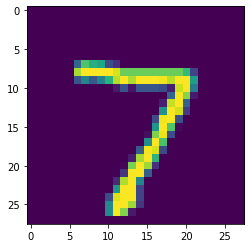

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test_adv = (y_test+1)%10
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_test_adv = tf.convert_to_tensor(y_test_adv)

plt.imshow(x_test[0])
print(y_test_adv[0])
print(y_test[0])

The NN model below is a 2 layered model with dropout regularization with dropout probability of 0.2. The relu activation unction is used in the hidden layer.

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

We are using Sparse Categorical Loss as the loss function. This is because we have multiple classes and the classes are not one hot encoded.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2991 - accuracy: 0.9132
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1470 - accuracy: 0.9565
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1098 - accuracy: 0.9666
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0887 - accuracy: 0.9728
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0775 - accuracy: 0.9759


In [ ]:
print("Model Accuracy is: ", model.evaluate(x_test,  y_test, verbose=2)[1])

313/313 - 0s - loss: 0.0689 - accuracy: 0.9791
Model Accuracy is:  0.9790999889373779


The code below creates perturbed images for untargeted attacks.

In [ ]:
def create_perturbed_image_untargeted(image_inp, label_t, epsilon):
  with tf.GradientTape() as g:
    g.watch(image_inp)
    prediction_t = model(image_inp)
    loss_t = loss_fn(label_t, prediction_t)
  gradient = g.gradient(loss_t, image_inp)
  signed_grad = tf.sign(gradient)
  new_image = image_inp + np.clip((epsilon * signed_grad), 0, 1)

  return new_image

The code below creates perturbed images for targeted attacks.

In [ ]:
def create_perturbed_image_targeted(image_inp, label_t, epsilon):
  with tf.GradientTape() as g:
    g.watch(image_inp)
    prediction_t = model(image_inp)
    loss_t = loss_fn(label_t, prediction_t)
  gradient = g.gradient(loss_t, image_inp)
  signed_grad = tf.sign(gradient)
  new_image = image_inp - np.clip((epsilon * signed_grad), 0, 1)

  return new_image

In [ ]:
epsilon = [1, 5, 10, 20, 30, 40, 50, 100]
a = [0]*8
n = 0

print("For untargeted FGSM:\n")
for k in epsilon:
  print("Epsilon: ", k)
  new_image = create_perturbed_image_untargeted(x_test, y_test, k/255)
  a[n] = model.evaluate(new_image, y_test, verbose=2)[1]
  n+=1
  print("\n")

For untargeted FGSM:

Epsilon:  1
313/313 - 0s - loss: 0.0847 - accuracy: 0.9749


Epsilon:  5
313/313 - 0s - loss: 0.1878 - accuracy: 0.9401


Epsilon:  10
313/313 - 0s - loss: 0.4685 - accuracy: 0.8495


Epsilon:  20
313/313 - 0s - loss: 1.7753 - accuracy: 0.4924


Epsilon:  30
313/313 - 0s - loss: 3.6995 - accuracy: 0.2350


Epsilon:  40
313/313 - 0s - loss: 5.7703 - accuracy: 0.1048


Epsilon:  50
313/313 - 0s - loss: 7.8521 - accuracy: 0.0493


Epsilon:  100
313/313 - 0s - loss: 18.6482 - accuracy: 0.0043




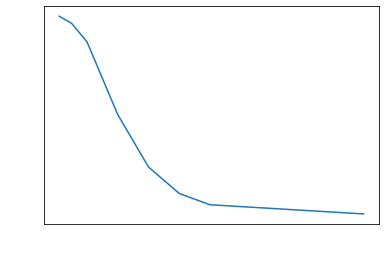

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.plot(epsilon, a)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epsilon')
ax.xaxis.label.set_color('white') # Please use dark theme to view the labels of the graph else remove the color code.
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors = 'white')
ax.tick_params(axis='y', colors = 'white')
plt.show()

In [ ]:
epsilon = [1, 5, 10, 20, 30, 40, 50, 100]
b = [0]*8
m = 0
print("For targeted FGSM:\n")
for k in epsilon:
  print("Epsilon: ", k)
  new_image_targeted = create_perturbed_image_targeted(x_test, y_test_adv, k/255)
  b[m] = model.evaluate(new_image_targeted,  y_test_adv, verbose=2)[1]
  m+=1
  print("\n")

For targeted FGSM:

Epsilon:  1
313/313 - 0s - loss: 15.5548 - accuracy: 0.0019


Epsilon:  5
313/313 - 0s - loss: 13.6739 - accuracy: 0.0073


Epsilon:  10
313/313 - 0s - loss: 11.4251 - accuracy: 0.0241


Epsilon:  20
313/313 - 0s - loss: 7.4734 - accuracy: 0.0966


Epsilon:  30
313/313 - 0s - loss: 4.5616 - accuracy: 0.2428


Epsilon:  40
313/313 - 0s - loss: 2.7609 - accuracy: 0.4367


Epsilon:  50
313/313 - 0s - loss: 1.7958 - accuracy: 0.5867


Epsilon:  100
313/313 - 0s - loss: 1.3348 - accuracy: 0.7492




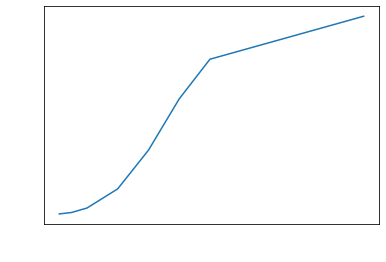

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.plot(epsilon, b)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epsilon')
ax.xaxis.label.set_color('white') # Please use dark theme to view the labels of the graph else remove the color code.
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors = 'white') 
ax.tick_params(axis='y', colors = 'white') 
plt.show()

The code below creates the new dataset that include the perturbed images.

In [ ]:
adv_image = create_perturbed_image_untargeted(x_test, y_test, 10/255)
New_x_train = np.append(x_train, adv_image, axis=0)
New_y_train = np.append(y_train, y_test, axis=0)

In [ ]:
new_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])
new_model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

new_model.fit(New_x_train, New_y_train, epochs=5)

Epoch 1/5
2188/2188 [==============================] - 4s 2ms/step - loss: 0.2750 - accuracy: 0.9205
Epoch 2/5
2188/2188 [==============================] - 4s 2ms/step - loss: 0.1286 - accuracy: 0.9620
Epoch 3/5
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0981 - accuracy: 0.9699
Epoch 4/5
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0792 - accuracy: 0.9757
Epoch 5/5
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0679 - accuracy: 0.9785


In [ ]:
print("Retrained model accuracy on original dataset is: ", new_model.evaluate(x_test, y_test, verbose=2)[1])
print("Retrained model accuracy on adversarial dataset is: ", new_model.evaluate(new_image, y_test, verbose=2)[1])

313/313 - 0s - loss: 0.0477 - accuracy: 0.9849
Retrained model accuracy on original dataset is:  0.9848999977111816
313/313 - 0s - loss: 0.9293 - accuracy: 0.8845
Retrained model accuracy on adversarial dataset is:  0.8845000267028809
